In [12]:
import micropip
await micropip.install('seaborn')

# Import required libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import calendar
import warnings
warnings.filterwarnings('ignore')

# 1. LOAD AND EXPLORE THE DATASET

In [45]:
# Load the NASDAQ dataset
df = pd.read_csv('nasdq.csv', parse_dates=['Date'])
df = df.sort_values('Date')  # Ensure chronological order
original_shape = df.shape
print(f"Dataset shape: {original_shape}")
print("\nFirst few rows of the dataset:")
print(df.head())
print("\nData types of each column:")
print(df.dtypes)
print("\nBasic statistics of numerical columns:")
print(df.describe())

Dataset shape: (3914, 13)

First few rows of the dataset:
        Date      Open      High       Low     Close     Volume  InterestRate  ExchangeRate    VIX  TEDSpread  EFFR         Gold        Oil
0 2010-01-04  6.640000  6.810000  6.633333  6.746667  6514500.0          0.11        1.4419  20.04       0.17  0.12  1117.699951  81.510002
1 2010-01-05  6.643333  6.773333  6.643333  6.766667  4445100.0          0.11        1.4402  19.35       0.18  0.12  1118.099976  81.769997
2 2010-01-06  6.733333  6.786667  6.720000  6.763333  7340100.0          0.11        1.4404  19.16       0.19  0.12  1135.900024  83.180000
3 2010-01-07  6.750000  6.766667  6.630000  6.673333  8498400.0          0.11        1.4314  19.06       0.20  0.10  1133.099976  82.660004
4 2010-01-08  6.676667  6.766667  6.626667  6.743333  4347600.0          0.11        1.4357  18.13       0.20  0.11  1138.199951  82.750000

Data types of each column:
Date            datetime64[ns]
Open                   float64
High        

# 3. HANDLE MISSING VALUES

In [46]:
print("\n\n=== IDENTIFYING MISSING VALUES ===")
print("Missing values before preprocessing:")
missing_before = df.isnull().sum()
print(missing_before)
print(f"\nTotal missing values: {missing_before.sum()}")

# Separate columns by type
price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
macro_cols = ['InterestRate', 'ExchangeRate', 'VIX', 'TEDSpread', 'EFFR', 'Gold', 'Oil']

# Handle missing values in price columns - forward fill
for col in price_cols:
    if df[col].isnull().sum() > 0:
        print(f"Filling missing values in {col} using forward fill")
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

# Handle missing values in macroeconomic columns - linear interpolation
for col in macro_cols:
    if df[col].isnull().sum() > 0:
        print(f"Filling missing values in {col} using interpolation")
        df[col] = df[col].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')        

print("\nMissing values after preprocessing:")
missing_after = df.isnull().sum()
print(missing_after)
print(f"\nTotal missing values remaining: {missing_after.sum()}")        



=== IDENTIFYING MISSING VALUES ===
Missing values before preprocessing:
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
InterestRate    0
ExchangeRate    0
VIX             0
TEDSpread       0
EFFR            0
Gold            0
Oil             0
dtype: int64

Total missing values: 0

Missing values after preprocessing:
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
InterestRate    0
ExchangeRate    0
VIX             0
TEDSpread       0
EFFR            0
Gold            0
Oil             0
dtype: int64

Total missing values remaining: 0


# 4. OUTLIERS and CORRELATION

# Set visual styling

In [92]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

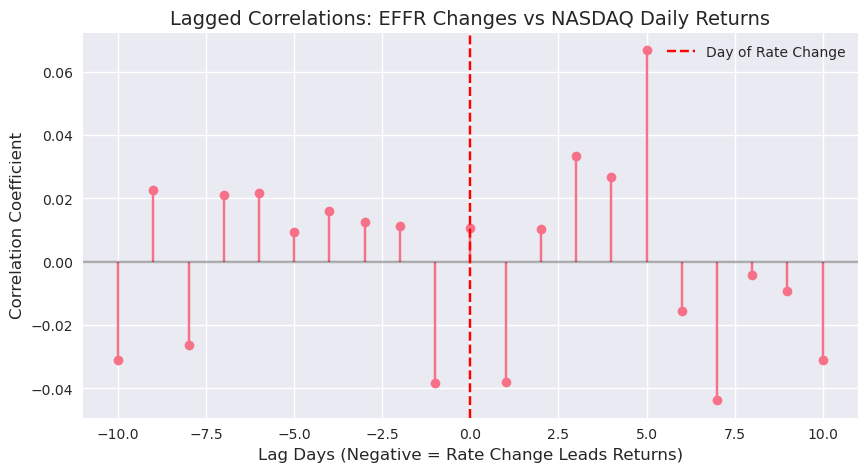

In [80]:
# Calculate lagged correlations between EFFR changes and NASDAQ returns
max_lag = 10  # Look at lags up to 10 days
lagged_correlations = []
lag_days = range(-max_lag, max_lag + 1)  # Include negative lags (NASDAQ leading rates)

# First calculate EFFR changes and NASDAQ returns
df['EFFR_Change'] = df['EFFR'].diff()
df['Daily_Return'] = df['Close'].pct_change() * 100

# Calculate correlations at different lags
for lag in lag_days:
    corr = df['EFFR_Change'].shift(lag).corr(df['Daily_Return'])
    lagged_correlations.append(corr)

# Now plot the lagged correlations
plt.figure(figsize=(10, 5))
plt.stem(lag_days, lagged_correlations, basefmt=" ")
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='red', linestyle='--', label='Day of Rate Change')
plt.xlabel('Lag Days (Negative = Rate Change Leads Returns)', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Lagged Correlations: EFFR Changes vs NASDAQ Daily Returns', fontsize=14)
plt.legend()

# Maximum Correlation with Duration

In [51]:
# Find the lag with maximum absolute correlation
max_corr_idx = np.argmax(np.abs(lagged_correlations))
optimal_lag = lag_days[max_corr_idx]
max_corr = lagged_correlations[max_corr_idx]
print(f"\nMaximum absolute correlation: {max_corr:.3f} at lag {optimal_lag} days")


Maximum absolute correlation: 0.067 at lag 5 days


# Outlier Analysis


=== COMPLETE OUTLIER ANALYSIS RESULTS ===

Dataset Shape: 3914 rows, 54 columns
Analysis Period: 2010-01-04 to 2024-10-25

=== STATISTICAL THRESHOLDS ===
Z-score threshold used: 3
Standard deviation threshold (3σ): ±4.6569%
Mean daily return: 0.0735%
Standard deviation of returns: 1.5523%

=== OUTLIER COUNTS BY VARIABLE ===
Close_return: 52 outliers (1.33%)
InterestRate_return: 33 outliers (0.84%)
ExchangeRate_return: 45 outliers (1.15%)
VIX_return: 57 outliers (1.46%)
TEDSpread_return: 62 outliers (1.58%)
EFFR_return: 60 outliers (1.53%)
Gold_return: 53 outliers (1.35%)
Oil_return: 12 outliers (0.31%)

=== SUMMARY STATISTICS FOR NASDAQ RETURNS ===
Total observations: 3913
Total outliers (|Z| > 3): 51
Outlier percentage: 1.30%
Maximum positive return: 13.8740%
Maximum negative return: -12.8397%
Median return: 0.0161%

=== OUTLIER DATES (TOP 10 MOST EXTREME) ===
Date: 2020-03-24, Return: 13.8740%
Date: 2013-04-02, Return: -12.8397%
Date: 2023-06-12, Return: -11.8105%
Date: 2020-03-17, 

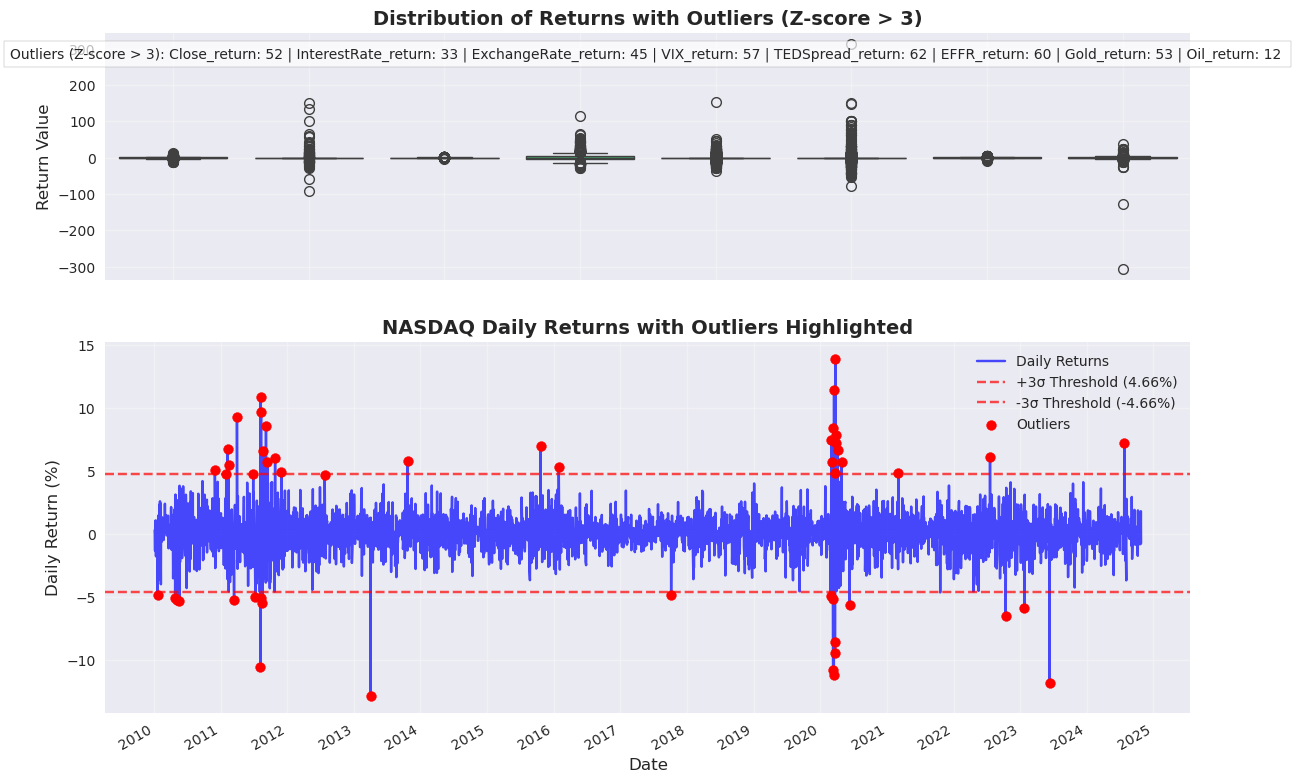

In [81]:
# Calculate daily returns
df['Daily_Return'] = df['Close'].pct_change() * 100

# Remove NaN values for analysis
returns_data = df['Daily_Return'].dropna()

# Calculate returns for relevant columns
return_columns = ['Close', 'InterestRate', 'ExchangeRate', 'VIX', 'TEDSpread', 'EFFR', 'Gold', 'Oil']
for col in return_columns:
    df[f'{col}_return'] = df[col].pct_change() * 100

# Identify outliers using Z-score > 3
z_threshold = 3
outlier_columns = [f'{col}_return' for col in return_columns if f'{col}_return' in df.columns]
outliers_dict = {}

for col in outlier_columns:
    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(df[col].dropna()))
    
    # Mark outliers
    df[f'{col}_outlier'] = (z_scores > z_threshold)
    outliers_dict[col] = df[df[f'{col}_outlier'] == True]

# Create the two-panel visualisation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1.5]})

# 1. Box plot of returns with outliers
sns.boxplot(data=df[outlier_columns], ax=ax1)
ax1.set_title('Distribution of Returns with Outliers (Z-score > 3)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Return Value', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add outlier count information
outlier_counts = {col: len(outliers_dict[col]) for col in outlier_columns}
outlier_text = "Outliers (Z-score > 3): "
for col in outlier_columns:
    if len(outliers_dict[col]) > 0:
        outlier_text += f"{col}: {len(outliers_dict[col])} | "
ax1.text(0.5, 0.9, outlier_text[:-2], 
        transform=ax1.transAxes, 
        ha='center', 
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# 2. Time Series with Simple Outlier Highlighting
ax2.plot(df['Date'], df['Daily_Return'], color='blue', alpha=0.7, label='Daily Returns')

# Detect outliers using standard deviation threshold (3 standard deviations)
mean_return = returns_data.mean()
std_return = returns_data.std()
outlier_threshold = 3 * std_return

# Add horizontal lines for outlier thresholds
ax2.axhline(y=mean_return + outlier_threshold, color='red', linestyle='--', alpha=0.7, label=f'+3σ Threshold ({outlier_threshold:.2f}%)')
ax2.axhline(y=mean_return - outlier_threshold, color='red', linestyle='--', alpha=0.7, label=f'-3σ Threshold ({-outlier_threshold:.2f}%)')

# Highlight actual outlier points
outliers = df[np.abs(df['Daily_Return']) > outlier_threshold]
ax2.scatter(outliers['Date'], outliers['Daily_Return'], color='red', s=50, zorder=5, label='Outliers')

ax2.set_title('NASDAQ Daily Returns with Outliers Highlighted', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Daily Return (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Format x-axis to show years clearly
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

# Print comprehensive outlier analysis statistics
print("\n=== COMPLETE OUTLIER ANALYSIS RESULTS ===")
print(f"\nDataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Analysis Period: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")

print("\n=== STATISTICAL THRESHOLDS ===")
print(f"Z-score threshold used: {z_threshold}")
print(f"Standard deviation threshold (3σ): ±{outlier_threshold:.4f}%")
print(f"Mean daily return: {mean_return:.4f}%")
print(f"Standard deviation of returns: {std_return:.4f}%")

print("\n=== OUTLIER COUNTS BY VARIABLE ===")
total_observations = len(returns_data)
for col in outlier_columns:
    count = len(outliers_dict[col])
    percentage = (count / total_observations) * 100
    print(f"{col}: {count} outliers ({percentage:.2f}%)")

print("\n=== SUMMARY STATISTICS FOR NASDAQ RETURNS ===")
print(f"Total observations: {total_observations}")
print(f"Total outliers (|Z| > 3): {len(outliers)}")
print(f"Outlier percentage: {(len(outliers) / total_observations) * 100:.2f}%")
print(f"Maximum positive return: {returns_data.max():.4f}%")
print(f"Maximum negative return: {returns_data.min():.4f}%")
print(f"Median return: {returns_data.median():.4f}%")

print("\n=== OUTLIER DATES (TOP 10 MOST EXTREME) ===")
extreme_outliers = outliers.sort_values('Daily_Return', key=abs, ascending=False).head(10)
for idx, row in extreme_outliers.iterrows():
    print(f"Date: {row['Date'].strftime('%Y-%m-%d')}, Return: {row['Daily_Return']:.4f}%")

# Handle Outliers

In [82]:
# Create a copy for outlier analysis to preserve original data
df_outlier_analysis = df.copy()

# Winsorisation function
def winsorize_series(series, percentile=0.01):
    """Winsorise a series at the given percentile"""
    lower_bound = np.percentile(series.dropna(), percentile * 100)
    upper_bound = np.percentile(series.dropna(), (1 - percentile) * 100)
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply winsorisation to returns (not prices) 
for col in return_columns:
    original_col = col.replace('_return', '')
    print(f"Winsorising outliers in {original_col} returns")
    df[f'{original_col}_winsorised'] = winsorize_series(df_outlier_analysis[f'{original_col}_return'])
    
    # For price columns, reconstruct the price series from winsorized returns
    if original_col in price_cols + ['Close']:
        # Calculate the cumulative product of (1 + returns) to get prices
        df[f'{original_col}_winsorised_price'] = df['Close'].iloc[0] * (1 + df[f'{original_col}_winsorised'] / 100).cumprod()
        print(f"Reconstructed {original_col} price series from winsorised returns")

print("\nOutlier handling complete. New columns created for winsorised data.")

Winsorising outliers in Close returns
Reconstructed Close price series from winsorised returns
Winsorising outliers in InterestRate returns
Winsorising outliers in ExchangeRate returns
Winsorising outliers in VIX returns
Winsorising outliers in TEDSpread returns
Winsorising outliers in EFFR returns
Winsorising outliers in Gold returns
Winsorising outliers in Oil returns

Outlier handling complete. New columns created for winsorised data.


# 6. Identify and Handle Data Incocnsistencies

In [83]:
# Check for negative prices
negative_prices = {}
for col in price_cols:
    neg_count = (df[col] < 0).sum()
    if neg_count > 0:
        negative_prices[col] = neg_count
        print(f"WARNING: {neg_count} negative values found in {col}")
        # Fix negative prices by taking absolute value
        df[col] = df[col].abs()
        print(f"Fixed negative values in {col} by taking absolute values")

# Check for unrealistic interest rates (e.g., rates > 100%)
unrealistic_rates = (df['InterestRate'] > 100).sum()
if unrealistic_rates > 0:
    print(f"WARNING: {unrealistic_rates} unrealistic interest rate values detected (InterestRate > 100%)")
    # Fix by forward filling from previous valid value
    invalid_mask = df['InterestRate'] > 100
    df.loc[invalid_mask, 'InterestRate'] = np.nan
    df['InterestRate'] = df['InterestRate'].fillna(method='ffill')
    print("Fixed unrealistic interest rates by forward filling")  

# Check for zero or negative volume
zero_volume = (df['Volume'] <= 0).sum()
if zero_volume > 0:
    print(f"WARNING: {zero_volume} zero or negative volume entries detected")
    # Fix by replacing with rolling median (7-day window)
    df['Volume_fixed'] = df['Volume'].replace(0, np.nan)
    df['Volume_fixed'] = df['Volume_fixed'].fillna(df['Volume_fixed'].rolling(window=7, min_periods=1).median())
    print("Fixed volume inconsistencies using rolling median") 

# Check for zero or negative volume
zero_volume = (df['Volume'] <= 0).sum()
if zero_volume > 0:
    print(f"WARNING: {zero_volume} zero or negative volume entries detected")
    # Fix by replacing with rolling median (7-day window)
    df['Volume_fixed'] = df['Volume'].replace(0, np.nan)
    df['Volume_fixed'] = df['Volume_fixed'].fillna(df['Volume_fixed'].rolling(window=7, min_periods=1).median())
    print("Fixed volume inconsistencies using rolling median")    

# Check for price inconsistencies where low > high
inconsistent_prices = (df['Low'] > df['High']).sum()
if inconsistent_prices > 0:
    print(f"WARNING: {inconsistent_prices} entries with Low > High price detected")
    # Fix by averaging the values
    mask = df['Low'] > df['High']
    df.loc[mask, 'Low'] = (df.loc[mask, 'Low'] + df.loc[mask, 'High']) / 2
    df.loc[mask, 'High'] = df.loc[mask, 'Low']
    print("Fixed price inconsistencies by averaging values")    

# 7. Data Type Validation and Standardisation

In [84]:
# 1. ENSURE CORRECT DATA TYPES
print("Validating and correcting data types...")

# Ensure numeric columns are float type
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'InterestRate', 
                'ExchangeRate', 'VIX', 'TEDSpread', 'EFFR', 'Gold', 'Oil']

# Convert Volume to integer first (special case)
if 'Volume' in df.columns:
    # Handle NaN values before conversion
    if df['Volume'].isnull().any():
        print("Filling missing Volume values before integer conversion")
        df['Volume'] = df['Volume'].fillna(method='ffill').fillna(method='bfill')
    # Round to nearest integer and convert to int
    df['Volume'] = df['Volume'].round().astype('int64')
    print("Volume column converted to integer type")

# Convert all other numeric columns to float
for col in numeric_cols:
    if col != 'Volume' and col in df.columns:  # Skip Volume as it's already handled
        if not pd.api.types.is_float_dtype(df[col]):
            print(f"Converting {col} to float type")
            # Handle potential string values that might contain commas or other non-numeric characters
            if df[col].dtype == 'object':
                df[col] = df[col].str.replace(',', '').str.replace('$', '').astype(float)
            else:
                df[col] = df[col].astype(float)

# 2. APPLY INDUSTRY STANDARDS FOR DECIMAL PLACES
print("\nApplying industry-standard decimal precision...")
# Columns requiring 2 decimal places
two_decimal_cols = ['Open', 'High', 'Low', 'Close',  # Stock prices
                   'InterestRate', 'EFFR',            # Interest rates
                   'Gold', 'Oil',                     # Commodities
                   'VIX']                             # Volatility index

for col in two_decimal_cols:
    if col in df.columns:
        df[col] = df[col].round(2)
        print(f"{col} standardized to 2 decimal places")

# Columns requiring 4 decimal places
four_decimal_cols = ['ExchangeRate',  # Forex standard
                    'TEDSpread']    # Credit spread standard

for col in four_decimal_cols:
    if col in df.columns:
        df[col] = df[col].round(4)
        print(f"{col} standardized to 4 decimal places")

# 3. VALIDATE FINAL DATA TYPES AND DECIMAL PLACES
print("\nValidating final data structure...")
print("Column data types after standardisation:")
print(df.dtypes)

print("\nSample of standardised data (first 3 rows):")
print(df.head(3).to_string(index=False, float_format='%.4f'))

# 5. SAVE THE FINAL CLEANED AND STANDARDISED DATASET
print("\n\n=== SAVING FINAL CLEANED AND STANDARDISED DATASET ===")
final_filename = 'nasdaq_cleaned_standardized_data.csv'
df.to_csv(final_filename, index=False)
print(f"Final standardised dataset saved as '{final_filename}'")
print(f"Dataset shape: {df.shape}")
print("Data type validation and standardisation complete!")

Validating and correcting data types...
Volume column converted to integer type

Applying industry-standard decimal precision...
Open standardized to 2 decimal places
High standardized to 2 decimal places
Low standardized to 2 decimal places
Close standardized to 2 decimal places
InterestRate standardized to 2 decimal places
EFFR standardized to 2 decimal places
Gold standardized to 2 decimal places
Oil standardized to 2 decimal places
VIX standardized to 2 decimal places
ExchangeRate standardized to 4 decimal places
TEDSpread standardized to 4 decimal places

Validating final data structure...
Column data types after standardisation:
Date                           datetime64[ns]
Open                                  float64
High                                  float64
Low                                   float64
Close                                 float64
Volume                                  int64
InterestRate                          float64
ExchangeRate                       

# 8. Feature Engineering and Normalisation

In [85]:
# Create additional meaningful features
print("Creating additional features...")
df['Daily_Return'] = df['Close'].pct_change() * 100
df['Volatility_10d'] = df['Daily_Return'].rolling(window=10).std()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# Normalise features
scaler = StandardScaler()
features_to_normalise = ['Daily_Return', 'Volatility_10d', 'InterestRate', 'VIX', 'Gold', 'Oil']
df_scaled = pd.DataFrame()
df_scaled[features_to_normalise] = scaler.fit_transform(df[features_to_normalise].fillna(0))
print("Normalisation complete for key features")

Creating additional features...
Normalisation complete for key features


# 9. Visualisation of  Data After Cleaning

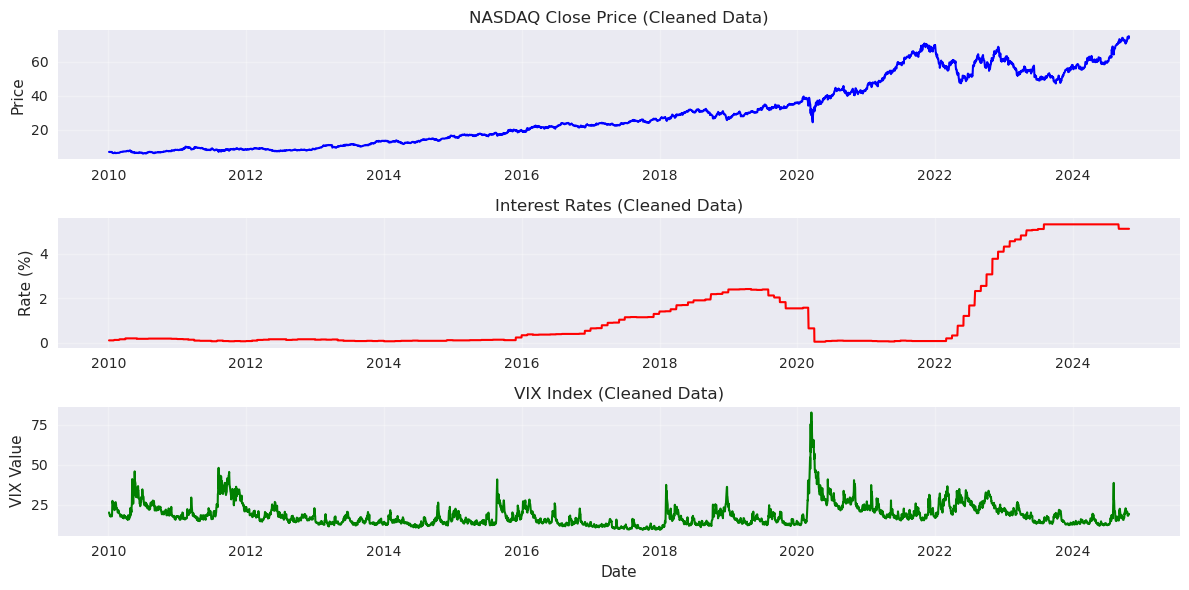

In [86]:
# Plot key time series after cleaning
plt.figure(figsize=(12, 6))

# NASDAQ Close Price
plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['Close'], 'b-', linewidth=1.5)
plt.title('NASDAQ Close Price (Cleaned Data)')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)

# Interest Rates
plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['InterestRate'], 'r-', linewidth=1.5)
plt.title('Interest Rates (Cleaned Data)')
plt.ylabel('Rate (%)')
plt.grid(True, alpha=0.3)

# VIX Index
plt.subplot(3, 1, 3)
plt.plot(df['Date'], df['VIX'], 'g-', linewidth=1.5)
plt.title('VIX Index (Cleaned Data)')
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()

# 10. DATA ANALYSIS

# Key Statistics for Interest Rate Change Analysis

In [87]:
# Define FOMC announcement dates
fomc_dates = [
    '2015-12-16', '2016-12-14', '2017-03-15', '2017-06-14', '2017-12-13',
    '2018-03-21', '2018-06-13', '2018-09-26', '2019-07-31', '2020-03-15',
    '2020-06-10', '2021-03-17', '2022-03-16', '2022-06-15', '2022-09-21',
    '2022-12-14', '2023-03-22', '2023-05-03', '2023-07-26', '2023-09-20',
    '2023-11-01', '2023-12-13', '2024-01-31', '2024-03-20', '2024-05-01'
]
fomc_dates = [pd.Timestamp(date) for date in fomc_dates]

# Create marker for FOMC days
df['Is_FOMC'] = df['Date'].isin(fomc_dates)

# Event study analysis for FOMC days
window_size = 5  # 5 days before and after
event_returns = []

for fed_date in fomc_dates:
    if fed_date in df['Date'].values:
        event_idx = df[df['Date'] == fed_date].index[0]
        start_idx = max(event_idx - window_size, 0)
        end_idx = min(event_idx + window_size + 1, len(df))
        
        if end_idx - start_idx > window_size * 1.5:
            window_data = df.iloc[start_idx:end_idx].copy()
            days_before = event_idx - start_idx
            window_data['Days_From_Event'] = range(-days_before, end_idx - event_idx)
            event_returns.append(window_data[['Days_From_Event', 'Daily_Return']])

# Calculate statistics
if event_returns:
    # Combine all event windows
    all_events = pd.concat(event_returns)
    
    # Calculate average returns by days from event
    avg_returns = all_events.groupby('Days_From_Event')['Daily_Return'].mean()
    
    # Calculate standard error of the mean (SEM)
    sem_returns = all_events.groupby('Days_From_Event')['Daily_Return'].sem()
    
    # Identify statistically significant days
    significant_days = []
    for day in avg_returns.index:
        lower_bound = avg_returns[day] - sem_returns[day]
        upper_bound = avg_returns[day] + sem_returns[day]
        if (lower_bound > 0) or (upper_bound < 0):
            significant_days.append(day)
    
    # Calculate FOMC vs non-FOMC statistics
    fomc_returns = df[df['Is_FOMC']]['Daily_Return'].dropna()
    non_fomc_returns = df[~df['Is_FOMC']]['Daily_Return'].dropna()
    
    # Calculate 3-sigma threshold
    std_return = df['Daily_Return'].std()
    threshold = 3 * std_return
    
    # Calculate outliers
    fomc_outliers = len(fomc_returns[np.abs(fomc_returns) > threshold])
    non_fomc_outliers = len(non_fomc_returns[np.abs(non_fomc_returns) > threshold])
    
    fomc_count = len(fomc_returns)
    non_fomc_count = len(non_fomc_returns)
    
    # TOP 7 STATISTICS FOR PRESENTATION
    print("\n=== TOP 7 KEY STATISTICS FOR INTEREST RATE SHOCK TRANSMISSION ANALYSIS ===")
    
    # 1. Statistically significant days (most important)
    print(f"\n1. Days with statistically significant returns: {significant_days}")
    
    # 2. Average return 1 day after announcement
    day1_return = avg_returns.get(1, 0)
    print(f"2. Average return 1 day after announcement (Day +1): {day1_return:.3f}%")
    
    # 3. Average return on announcement day
    day0_return = avg_returns.get(0, 0)
    print(f"3. Average return on announcement day (Day 0): {day0_return:.3f}%")
    
    # 4. Average return 2 days after announcement
    day2_return = avg_returns.get(2, 0)
    print(f"4. Average return 2 days after announcement (Day +2): {day2_return:.3f}%")
    
    # 5. Maximum average return
    max_return = avg_returns.max()
    max_day = avg_returns.idxmax()
    print(f"5. Maximum average return: {max_return:.3f}% on Day {max_day}")
    
    # 6. Extreme returns comparison
    fomc_outlier_pct = (fomc_outliers / fomc_count) * 100 if fomc_count > 0 else 0
    non_fomc_outlier_pct = (non_fomc_outliers / non_fomc_count) * 100 if non_fomc_count > 0 else 0
    print(f"6. FOMC days with extreme returns (>3σ): {fomc_outliers} ({fomc_outlier_pct:.1f}%)")
    print(f"   Non-FOMC days with extreme returns (>3σ): {non_fomc_outliers} ({non_fomc_outlier_pct:.1f}%)")
    
    # 7. Average absolute returns comparison
    fomc_abs_return = np.abs(fomc_returns).mean()
    non_fomc_abs_return = np.abs(non_fomc_returns).mean()
    print(f"7. Average absolute return on FOMC days: {fomc_abs_return:.3f}%")
    print(f"   Average absolute return on non-FOMC days: {non_fomc_abs_return:.3f}%")


=== TOP 7 KEY STATISTICS FOR INTEREST RATE SHOCK TRANSMISSION ANALYSIS ===

1. Days with statistically significant returns: [-5, -4, -2, 0, 1]
2. Average return 1 day after announcement (Day +1): -0.602%
3. Average return on announcement day (Day 0): -0.433%
4. Average return 2 days after announcement (Day +2): 0.018%
5. Maximum average return: 0.307% on Day -2
6. FOMC days with extreme returns (>3σ): 0 (0.0%)
   Non-FOMC days with extreme returns (>3σ): 51 (1.3%)
7. Average absolute return on FOMC days: 1.231%
   Average absolute return on non-FOMC days: 1.044%


# Further Statistical Analysis

In [91]:
# Create a marker for FOMC announcement days
df['Is_FOMC_Day'] = df['Date'].isin(fomc_dates)
df['Is_FOMC_Window'] = False
for date in fomc_dates:
    window_start = date - pd.Timedelta(days=2)
    window_end = date + pd.Timedelta(days=5)
    df.loc[(df['Date'] >= window_start) & (df['Date'] <= window_end), 'Is_FOMC_Window'] = True

# BASIC SUMMARY STATISTICS
print("\n\n=== SUMMARY STATISTICS FOR KEY VARIABLES ===")
summary_stats = df.describe()
print(summary_stats[['Close', 'EFFR', 'VIX', 'TEDSpread', 'Volume']])

# Find the lag with maximum absolute correlation
max_corr_idx = np.argmax(np.abs(lagged_correlations))
optimal_lag = lag_days[max_corr_idx]
max_corr = lagged_correlations[max_corr_idx]
print(f"\nMaximum absolute correlation: {max_corr:.3f} at lag {optimal_lag} days")



=== SUMMARY STATISTICS FOR KEY VARIABLES ===
             Close         EFFR          VIX    TEDSpread        Volume
count  3914.000000  3914.000000  3914.000000  3914.000000  3.914000e+03
mean     29.226916     1.189384    18.374990     0.241193  3.708611e+06
min       5.770000     0.040000     9.140000     0.060000  5.754000e+05
25%      11.025000     0.090000    13.570000     0.130000  2.035875e+06
50%      23.730000     0.190000    16.605000     0.210000  2.834950e+06
75%      47.330000     1.700000    21.157500     0.320000  4.276500e+06
max      75.240000     5.330000    82.690000     1.420000  5.478960e+07
std      19.668599     1.684429     6.965917     0.148833  3.035420e+06

Maximum absolute correlation: 0.067 at lag 5 days


# Market Reactions around FOMC Announcement Days

In [89]:
print("\n\n=== ANALYSING MARKET REACTIONS AROUND FOMC ANNOUNCEMENTS ===")

# Create event study analysis for FOMC days
window_size = 10  # 10 days before and after
event_returns = []

for fed_date in fomc_dates:
    # Check if date exists in our dataset
    if fed_date in df['Date'].values:
        event_idx = df[df['Date'] == fed_date].index[0]
        start_idx = max(event_idx - window_size, 0)
        end_idx = min(event_idx + window_size + 1, len(df))
        
        if end_idx - start_idx > window_size * 1.5:  # Ensure we have enough data points
            window_data = df.iloc[start_idx:end_idx].copy()
            window_data['Days_From_Event'] = range(-len(window_data[:event_idx-start_idx]), 
                                                   len(window_data[event_idx-start_idx:]))
            event_returns.append(window_data[['Days_From_Event', 'Daily_Return', 'VIX', 'EFFR_Change']])

# Combine all event windows
if event_returns:
    all_events = pd.concat(event_returns)
    
    # Calculate average returns by days from event
    avg_returns = all_events.groupby('Days_From_Event')['Daily_Return'].mean()
    sem_returns = all_events.groupby('Days_From_Event')['Daily_Return'].sem()
    
    # Print key statistics
    print("\nAverage NASDAQ returns around FOMC announcements:")
    print(f"Day -2 (2 days before): {avg_returns.get(-2, 0):.3f}%")
    print(f"Day -1 (1 day before): {avg_returns.get(-1, 0):.3f}%")
    print(f"Day 0 (announcement day): {avg_returns.get(0, 0):.3f}%")
    print(f"Day +1 (1 day after): {avg_returns.get(1, 0):.3f}%")
    print(f"Day +2 (2 days after): {avg_returns.get(2, 0):.3f}%")
    print(f"Day +5 (5 days after): {avg_returns.get(5, 0):.3f}%")



=== ANALYSING MARKET REACTIONS AROUND FOMC ANNOUNCEMENTS ===

Average NASDAQ returns around FOMC announcements:
Day -2 (2 days before): 0.307%
Day -1 (1 day before): 0.214%
Day 0 (announcement day): -0.433%
Day +1 (1 day after): -0.602%
Day +2 (2 days after): 0.018%
Day +5 (5 days after): 0.227%


# Interest Rate Effects on Volatility 



=== VOLATILITY ANALYSIS DURING INTEREST RATE SHOCKS ===

Number of interest rate shock days identified: 41

Volatility change statistics after rate shocks:
Average volatility increase: 30.84%
Number of events with increased volatility: 16/41
Correlation between shock size and volatility change: -0.038


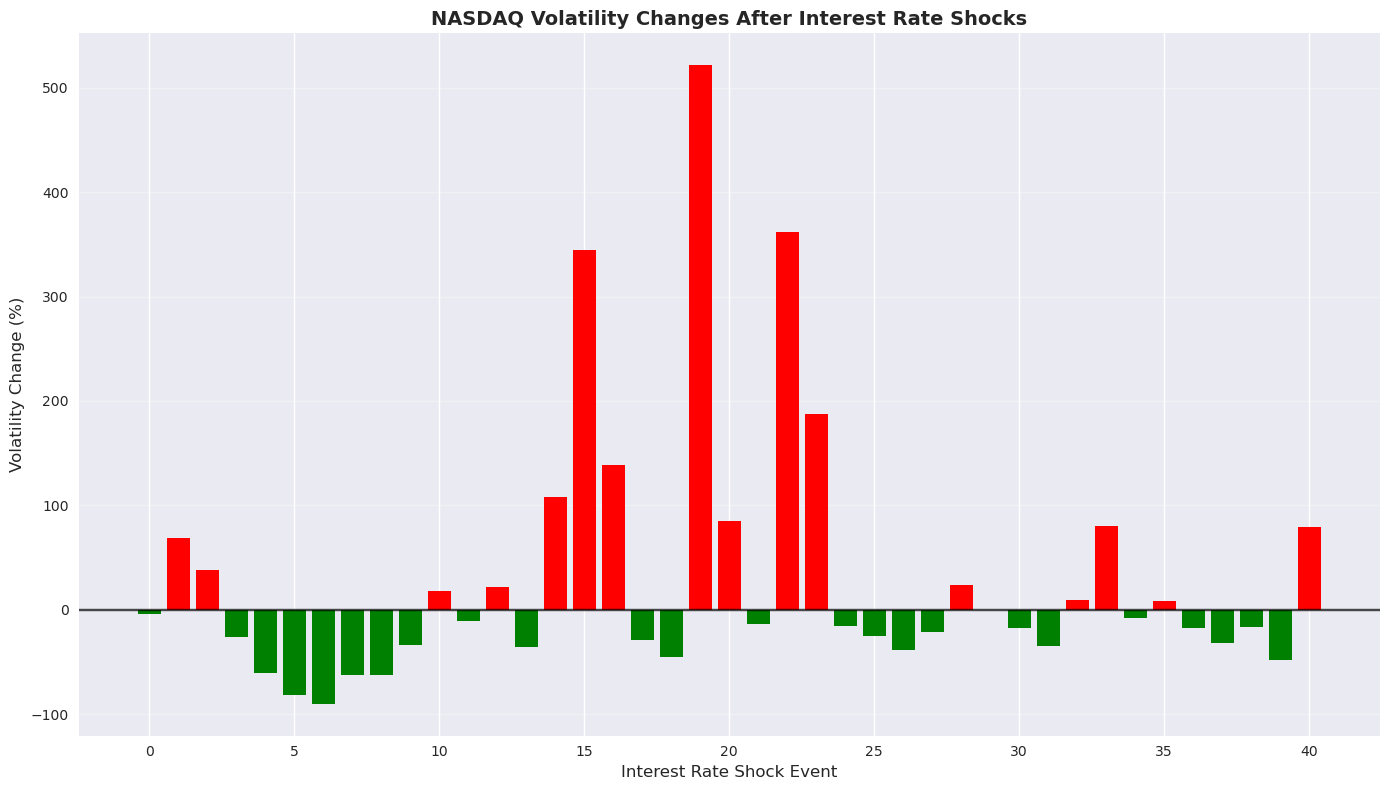

In [90]:
# VOLATILITY ANALYSIS DURING INTEREST RATE SHOCKS
print("\n\n=== VOLATILITY ANALYSIS DURING INTEREST RATE SHOCKS ===")

# Interest rate shocks are days with EFFR changes > 0.1%
rate_shocks = df[np.abs(df['EFFR_Change']) > 0.1]
print(f"\nNumber of interest rate shock days identified: {len(rate_shocks)}")

# Calculate volatility before, during, and after rate shocks
volatility_window = 5  # days
shock_effects = []

for shock_date in rate_shocks['Date']:
    shock_idx = df[df['Date'] == shock_date].index[0]
    
    if shock_idx > volatility_window and shock_idx + volatility_window < len(df):
        # Get returns for windows around shock
        before_returns = df.iloc[shock_idx-volatility_window:shock_idx]['Daily_Return']
        after_returns = df.iloc[shock_idx:shock_idx+volatility_window]['Daily_Return']
        
        before_vol = before_returns.std()
        after_vol = after_returns.std()
        shock_change = df.iloc[shock_idx]['EFFR_Change']
        
        shock_effects.append({
            'Date': shock_date,
            'Shock_Size': shock_change,
            'Vol_Before': before_vol,
            'Vol_After': after_vol,
            'Vol_Change': after_vol - before_vol,
            'Vol_Change_Pct': (after_vol - before_vol) / before_vol * 100
        })

if shock_effects:
    shock_df = pd.DataFrame(shock_effects)
    
    # Plot volatility changes
    plt.figure(figsize=(14, 8))
    plt.bar(range(len(shock_df)), shock_df['Vol_Change_Pct'], color=np.where(shock_df['Vol_Change_Pct'] > 0, 'red', 'green'))
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)
    plt.xlabel('Interest Rate Shock Event', fontsize=12)
    plt.ylabel('Volatility Change (%)', fontsize=12)
    plt.title('NASDAQ Volatility Changes After Interest Rate Shocks', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # Summary statistics
    print("\nVolatility change statistics after rate shocks:")
    print(f"Average volatility increase: {shock_df['Vol_Change_Pct'].mean():.2f}%")
    print(f"Number of events with increased volatility: {(shock_df['Vol_Change_Pct'] > 0).sum()}/{len(shock_df)}")
    print(f"Correlation between shock size and volatility change: {shock_df['Shock_Size'].abs().corr(shock_df['Vol_Change_Pct']):.3f}")

# Asset Reactions to Interest Rates

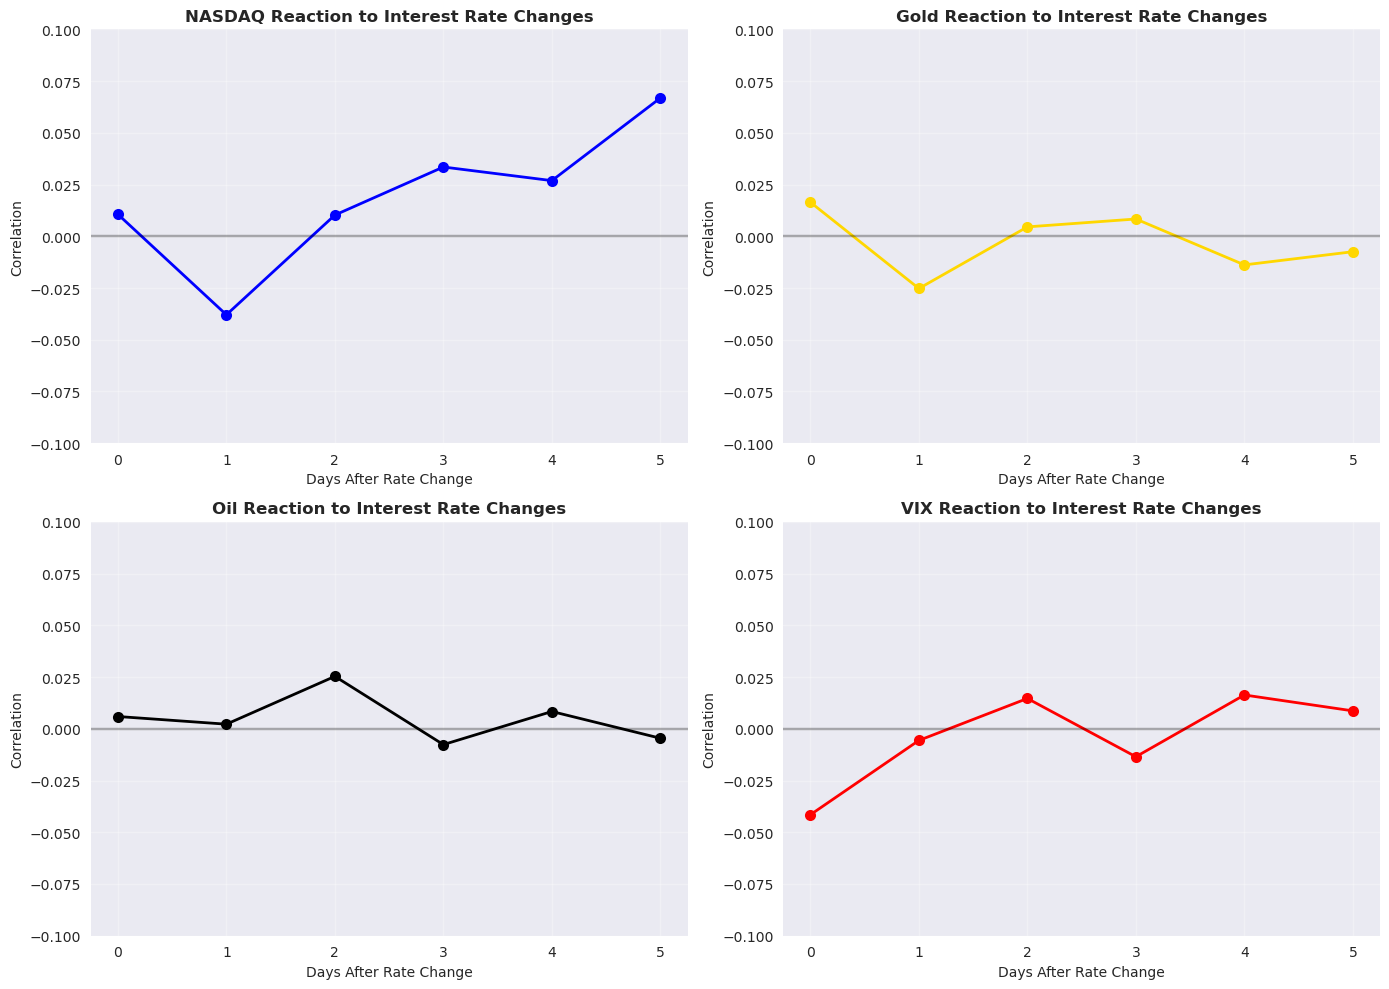

In [72]:
# ASSET CLASS REACTIONS TO INTEREST RATE SHOCKS

# Analyze how different asset classes react to rate changes
asset_classes = ['Close', 'Gold', 'Oil', 'VIX']
lag_analysis = {}

for asset in asset_classes:
    asset_returns = df[asset].pct_change() * 100 if asset != 'VIX' else df[asset].diff()
    
    correlations_by_lag = []
    for lag in range(0, 6):  # 0 to 5 day lags
        corr = df['EFFR_Change'].shift(lag).corr(asset_returns)
        correlations_by_lag.append(corr)
    
    lag_analysis[asset] = correlations_by_lag

# Plot asset class reactions
plt.figure(figsize=(14, 10))
colors = {'Close': 'blue', 'Gold': 'gold', 'Oil': 'black', 'VIX': 'red'}

for i, asset in enumerate(asset_classes):
    plt.subplot(2, 2, i+1)
    asset_name = asset if asset != 'Close' else 'NASDAQ'
    plt.plot(range(6), lag_analysis[asset], 'o-', color=colors[asset], linewidth=2, markersize=8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Days After Rate Change', fontsize=10)
    plt.ylabel('Correlation', fontsize=10)
    plt.title(f'{asset_name} Reaction to Interest Rate Changes', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.1, 0.1)  # Standardize y-axis for comparison

plt.tight_layout()

# Transmission Latency Analysis



=== TRANSMISSION LATENCY METRIC ANALYSIS ===

Transmission latency statistics (days to 50% max response):
Average latency: 7.75 days
Median latency: 6.00 days
Standard deviation: 5.17 days
Number of shocks analyzed: 114


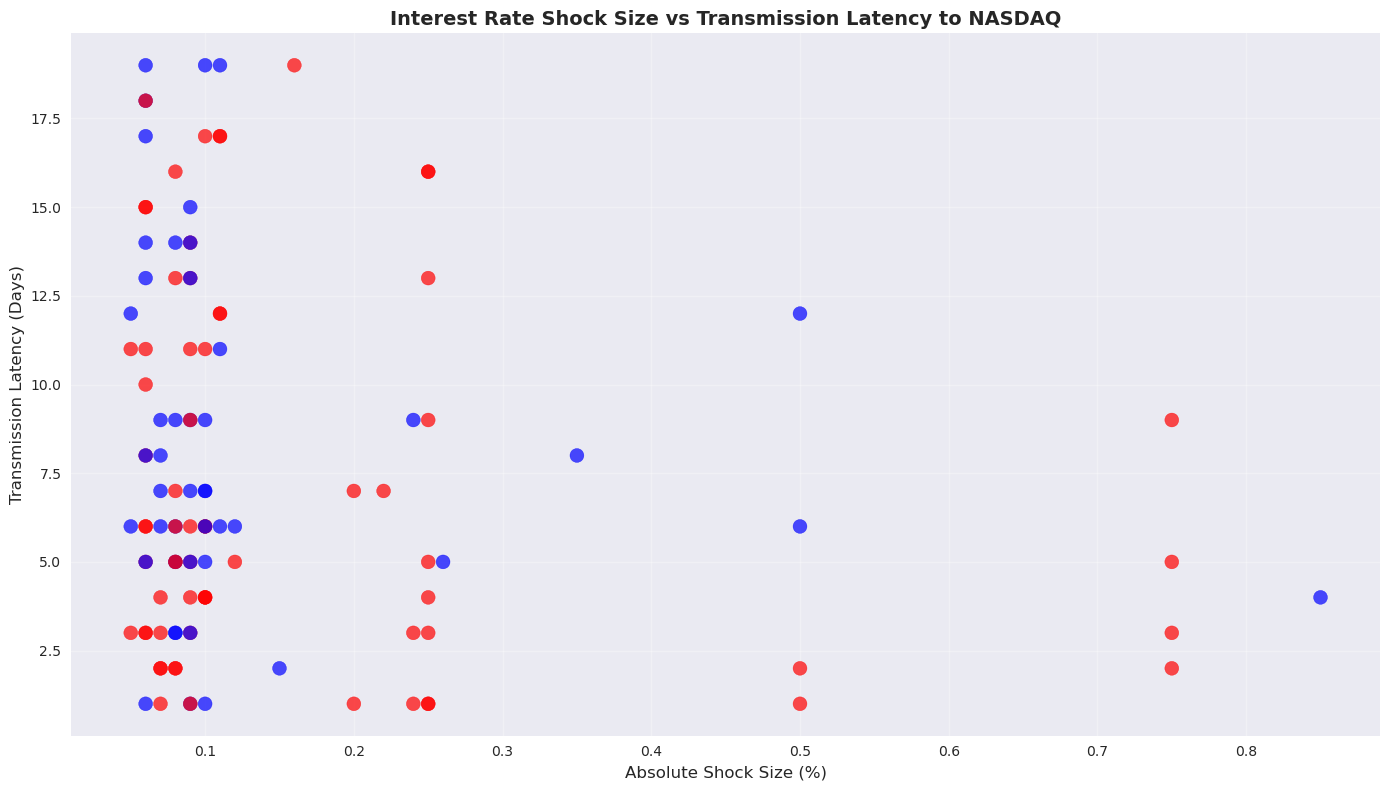

In [73]:
print("\n\n=== TRANSMISSION LATENCY METRIC ANALYSIS ===")

# Transmission latency is  the number of days until cumulative return reaches 50% of max response
transmission_latencies = []
significant_shocks = df[np.abs(df['EFFR_Change']) > 0.05]  # Only consider significant shocks

for shock_date in significant_shocks['Date']:
    shock_idx = df[df['Date'] == shock_date].index[0]
    
    if shock_idx + 20 < len(df):  # Ensure we have 20 days after shock
        shock_val = df.iloc[shock_idx]['EFFR_Change']
        cumulative_returns = []
        
        # Calculate cumulative returns for 20 days after shock
        for day in range(1, 21):
            if shock_idx + day < len(df):
                cumulative_return = df.iloc[shock_idx:shock_idx+day+1]['Daily_Return'].sum()
                cumulative_returns.append(cumulative_return)
        
        if cumulative_returns:
            max_response = max(cumulative_returns, key=abs)  # Get extreme response
            threshold = 0.5 * max_response  # 50% of maximum response
            
            # Find first day where cumulative return exceeds threshold
            latency = None
            for day, cum_return in enumerate(cumulative_returns, 1):
                if (cum_return > 0 and threshold > 0 and cum_return >= threshold) or \
                   (cum_return < 0 and threshold < 0 and cum_return <= threshold):
                    latency = day
                    break
            
            if latency:
                transmission_latencies.append({
                    'Date': shock_date,
                    'Shock_Size': shock_val,
                    'Latency_Days': latency,
                    'Max_Response': max_response,
                    'Shock_Direction': 'increase' if shock_val > 0 else 'decrease'
                })

if transmission_latencies:
    latency_df = pd.DataFrame(transmission_latencies)
    
    # Summary statistics
    avg_latency = latency_df['Latency_Days'].mean()
    median_latency = latency_df['Latency_Days'].median()
    std_latency = latency_df['Latency_Days'].std()
    
    print(f"\nTransmission latency statistics (days to 50% max response):")
    print(f"Average latency: {avg_latency:.2f} days")
    print(f"Median latency: {median_latency:.2f} days")
    print(f"Standard deviation: {std_latency:.2f} days")
    print(f"Number of shocks analyzed: {len(latency_df)}")
    
    # Plot latency by shock size
    plt.figure(figsize=(14, 8))
    plt.scatter(latency_df['Shock_Size'].abs(), latency_df['Latency_Days'], 
               c=np.where(latency_df['Shock_Direction']=='increase', 'red', 'blue'),
               s=100, alpha=0.7)
    plt.xlabel('Absolute Shock Size (%)', fontsize=12)
    plt.ylabel('Transmission Latency (Days)', fontsize=12)
    plt.title('Interest Rate Shock Size vs Transmission Latency to NASDAQ', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# EFFR Changes against Daily Returns

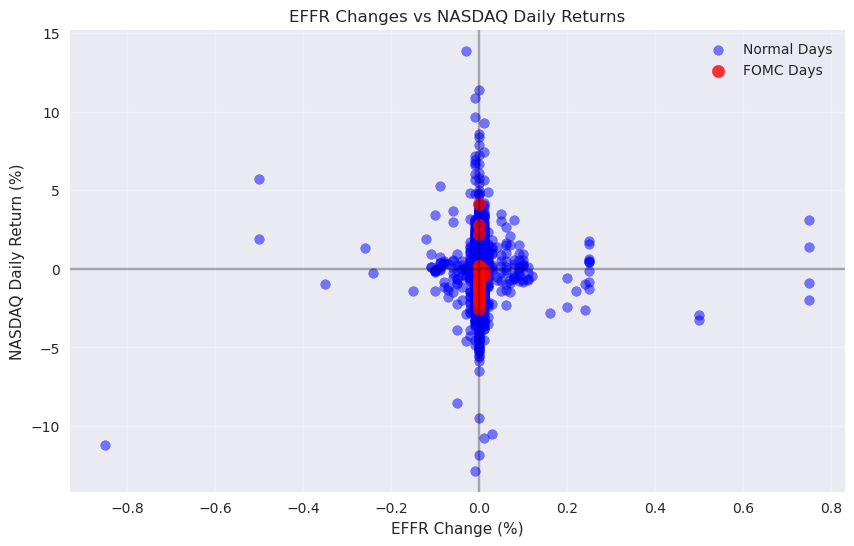

In [78]:
# SCATTER PLOT SHOWING RELATIONSHIP BETWEEN EFFR CHANGES AND RETURNS
plt.figure(figsize=(10, 6))

# Plot all points
plt.scatter(df['EFFR_Change'], df['Daily_Return'], alpha=0.5, color='blue', label='Normal Days')

# Highlight FOMC dates
fomc_df = df[df['Date'].isin(fomc_dates)]
plt.scatter(fomc_df['EFFR_Change'], fomc_df['Daily_Return'], 
           color='red', s=80, alpha=0.8, label='FOMC Days')

plt.title('EFFR Changes vs NASDAQ Daily Returns')
plt.xlabel('EFFR Change (%)')
plt.ylabel('NASDAQ Daily Return (%)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)

In [79]:
print("\n\n=== DATA EXPLORATION COMPLETE ===")



=== DATA EXPLORATION COMPLETE ===
